#**인공지능을 활용한 얼굴 탐지 및 감정 분석** 😀

####Original source code :
https://github.com/ageitgey/face_recognition



####Machine Learning is Fun! Part 4: Modern Face Recognition with Deep Learning :
https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78



####FER 2013 Train data :
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data


### FER(Facial Emotion Recognition) Reference :
https://magicode.tistory.com/72


<br>

<br>
<br>


---
---
---


<br>
<br>

#Mount Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).




---


#Import Library

In [14]:
#install dlib face_recognition
!pip install face_recognition

In [15]:
# 데이터 확인
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
import face_recognition

# Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import batch_normalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator



---


#GPU 사용 설정
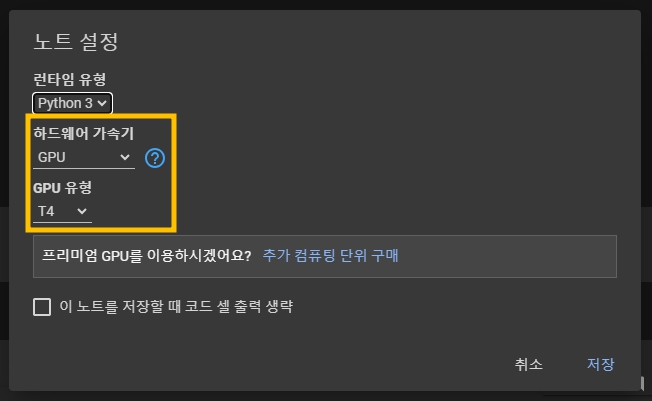

In [16]:
import torch
print("GPU 사용 가능 여부 :", torch.cuda.is_available())

GPU 사용 가능 여부 : True


<br>
<br>


---
---
---


<br>
<br>

#Load the jpg file

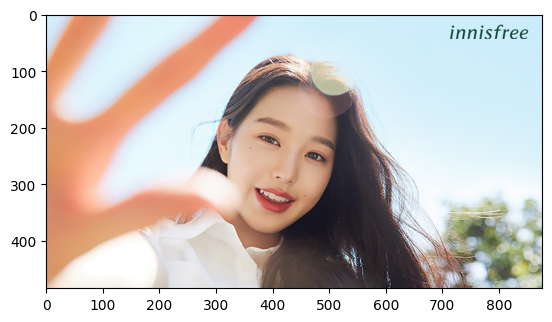

In [35]:
# Load the jpg file
data_path = '/content/gdrive/MyDrive/Emotion_Classification/Face_Data/'
image = face_recognition.load_image_file(data_path + 'Jang_Won-young_0000.jpg')
plt.imshow(image)

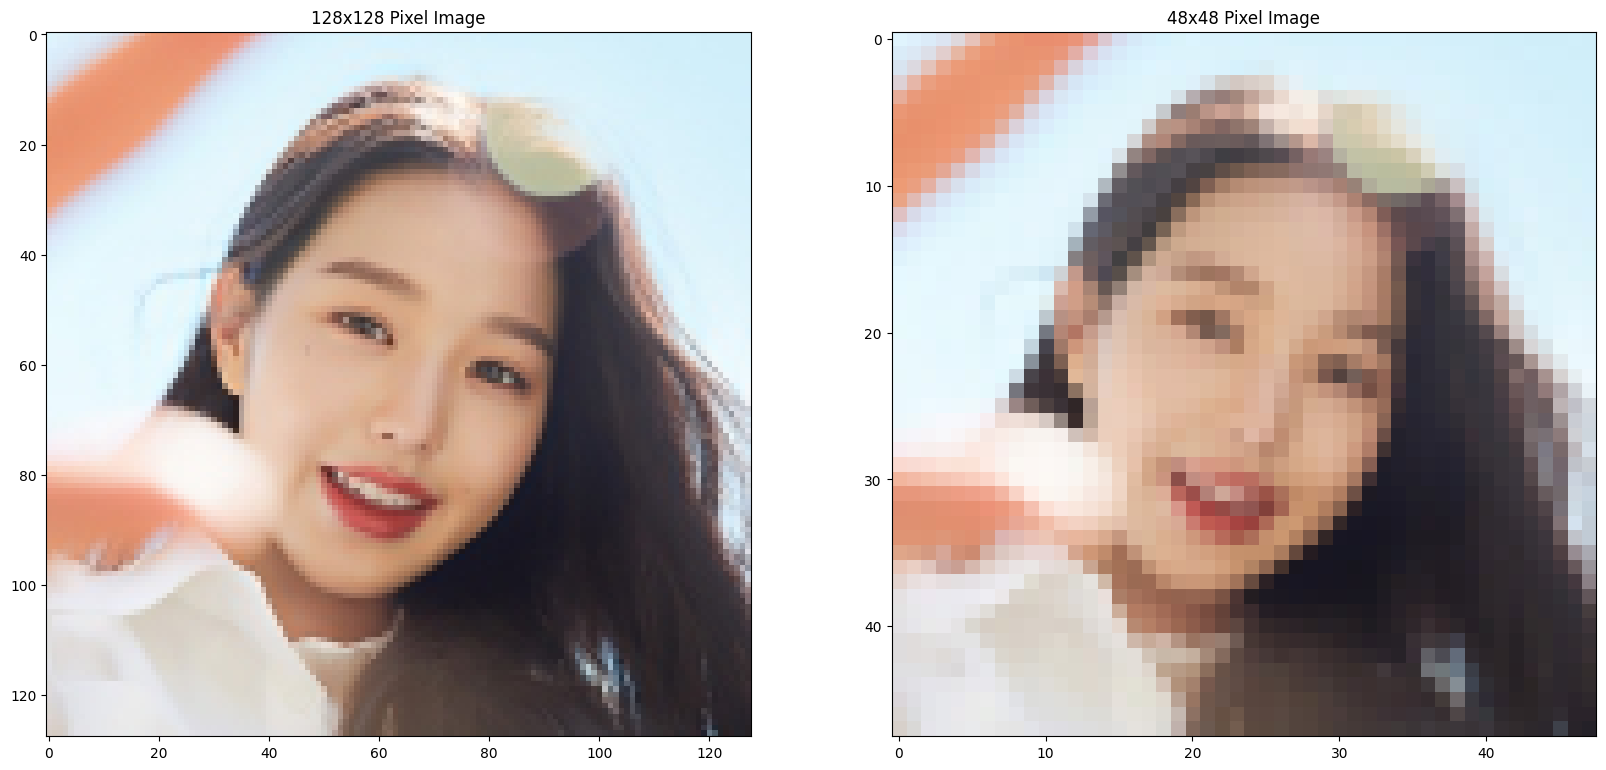

In [18]:
plt.figure(figsize=[20,10])

resize_image_128 = face_recognition.load_image_file(data_path + 'Jang_Won-young_0000_128x128.jpg')
plt.subplot(121)
plt.title("128x128 Pixel Image")
plt.imshow(resize_image_128)

resize_image_48 = face_recognition.load_image_file(data_path + 'Jang_Won-young_0000_48x48.jpg')
plt.subplot(122)
plt.title("48x48 Pixel Image")
plt.imshow(resize_image_48)

plt.show()

In [19]:
print("48x48 Pixel Image의 첫번째 행의 데이터 :", "\n")
print("   R   G   B")
print(resize_image_48[0])

48x48 Pixel Image의 첫번째 행의 데이터 : 

   R   G   B
[[224 244 253]
 [222 240 252]
 [219 235 248]
 [220 228 241]
 [222 216 220]
 [231 194 185]
 [233 166 137]
 [234 151 117]
 [233 147 112]
 [233 142 111]
 [233 142 111]
 [234 143 112]
 [234 148 121]
 [228 165 156]
 [220 200 209]
 [215 222 240]
 [214 233 248]
 [215 239 251]
 [214 242 253]
 [218 243 250]
 [220 244 254]
 [218 242 252]
 [218 242 252]
 [218 242 254]
 [216 243 252]
 [218 242 252]
 [217 241 251]
 [214 241 250]
 [214 241 250]
 [214 241 250]
 [214 241 252]
 [214 241 252]
 [213 241 252]
 [213 241 252]
 [214 241 252]
 [213 240 251]
 [213 240 251]
 [212 240 251]
 [211 239 250]
 [211 239 250]
 [211 239 250]
 [209 239 249]
 [209 239 250]
 [208 238 249]
 [208 238 249]
 [208 238 249]
 [209 239 250]
 [208 238 249]]


---
#Detect face using HOG(Histogram of Oriented Gradients)

In [20]:
def detect_face(image) :

  face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=0, model="cnn")

  print("I found {} face(s) in this photograph.".format(len(face_locations)), end="\n")

  for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location

    #You can adjust the offset values to change the size of the detected face :

    offset = 15
    top, left, bottom, right = top - offset, left - offset, bottom + offset, right + offset

    print("\nA face is located at pixel location(offset : {}) Top: {}, Left: {}, Bottom: {}, Right: {}\n".format(offset, top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]

  plt.figure(figsize=[16,9])
  plt.subplot(121)
  plt.title("Original Image")
  plt.imshow(image)

  plt.subplot(122)
  plt.title("Extracted Face")
  plt.imshow(face_image)

  plt.savefig("Detect_Face_Result", dpi=300)
  plt.show()

  gray_face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY) # Convert RGB image to gray scale image
  gray_face_image = cv2.resize(gray_face_image, (48, 48))
  gray_face_image = np.reshape(gray_face_image, (1, 48, 48, 1))
  gray_face_image = gray_face_image / 255.0

  return face_image, gray_face_image

<br>
<br>


---


# **실습1. 이미지 불러오기**

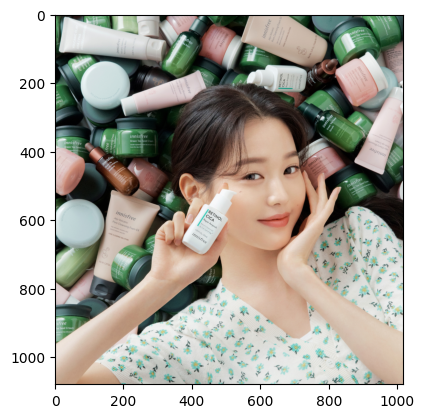

In [32]:
# Load the jpg file
image = face_recognition.load_image_file(data_path + 'Jang_Won-young_0022.jpg')
plt.imshow(image)



---


# **실습2. HOG 알고리즘을 사용해서 이미지에서 얼굴 검출하기**

I found 1 face(s) in this photograph.

A face is located at pixel location(offset : 15) Top: 338, Left: 464, Bottom: 651, Right: 777



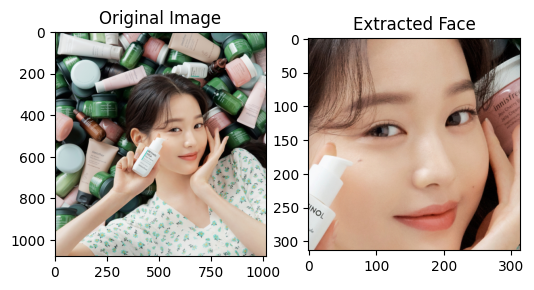

In [33]:
face_image, gray_face_image = detect_face(image)

<br>
<br>


---
---
---


<br>
<br>

#Facial Emotion Recognition using simple model

###Load FER2013 data

In [23]:
# 데이터 확인
df = pd.read_csv('/content/gdrive/MyDrive/Emotion_Classification/' + 'fer2013/fer2013.csv')
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))
print(df.head())

   emotion                                             pixels     Usage
0        0  [70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....  Training
1        0  [151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...  Training
2        2  [231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...  Training
3        4  [24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....  Training
4        6  [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  Training




---


####Create dataset | 데이터세트 생성

In [24]:
# train test 나누기
train_df = df[df['Usage']=='Training']
test_df = df[df['Usage']=='PublicTest']
print(train_df.shape)
print(test_df.shape)


shape_x = 48
shape_y = 48

# X_train, y_train, X_test, y_test split
X_train = train_df.iloc[:, 1].values # pixles
y_train = train_df.iloc[:, 0].values # emotion

X_test = test_df.iloc[:, 1].values # pixles
y_test = test_df.iloc[:, 0].values # emotion

# 전체데이터
X = df.iloc[:, 1].values # pixles
y = df.iloc[:, 0].values # emotion

# array([array([....])]) 구조를 바꾸기 위한 np.vstack
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)


# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))

X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_ds.shape, y_train_ds.shape)
print(X_test_ds.shape, y_test_ds.shape)


# 데이터타입 float로 변경
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 스케일링
train_data /= 225
test_data /= 225

# y데이터 원핫인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1:]
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(28709, 3)
(3589, 3)
(28709, 48, 48, 1) (28709, 1)
(3589, 48, 48, 1) (3589, 1)
(48, 48, 1)




---


###라벨 숫자를 문자로 변경

In [25]:
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, 'Invalid emotion'))

Text(0.5, 1.0, 'Ground Truth : Neutral')

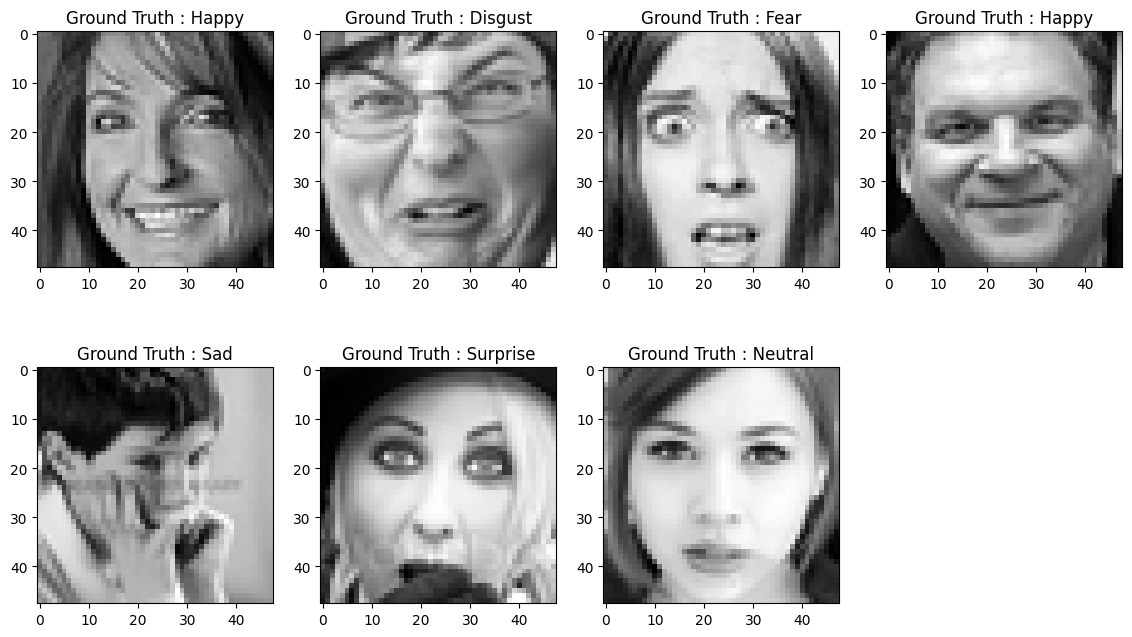

In [26]:
# 데이터 시각화
plt.figure(figsize=[14,8])

plt.subplot(241) #0
plt.imshow(np.squeeze(X_train_ds[105,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[105]))))

plt.subplot(242) #1
plt.imshow(np.squeeze(X_train_ds[299,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[299]))))

plt.subplot(243) #2
plt.imshow(np.squeeze(X_train_ds[96,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[96]))))

plt.subplot(244) #3
plt.imshow(np.squeeze(X_train_ds[14,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[14]))))

plt.subplot(245) #4
plt.imshow(np.squeeze(X_train_ds[3,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[3]))))

plt.subplot(246) #5
plt.imshow(np.squeeze(X_train_ds[1681,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1681]))))

plt.subplot(247) #6
plt.imshow(np.squeeze(X_train_ds[2223,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[2223]))))



---




### Build FER model

In [27]:
# 감정 분석 모델 구축         ------------------------------------------------------------

def simple_model():
    model = Sequential()

    # Input layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Add layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Flatten
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(512, activation='relu'))

    # Output layer : n_classes=7
    model.add(Dense(7, activation='softmax'))

    return model


model = simple_model()
model.summary()


# 마지막 Dense 레이어 2개를 제외한 레이어별 out 담기
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 시각화 할 때 어떤 레이어인지 확인할 수 있도록 레이어 이름 담기
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        36928     
                                                        

### Visualization model : Model task step별 Facetest image 시각화

1/1 [==============================] - 0s 188ms/step


<ipython-input-28-db075da21df8>:15: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


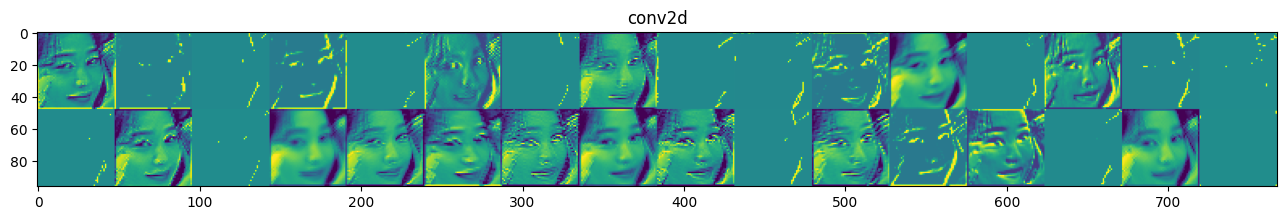

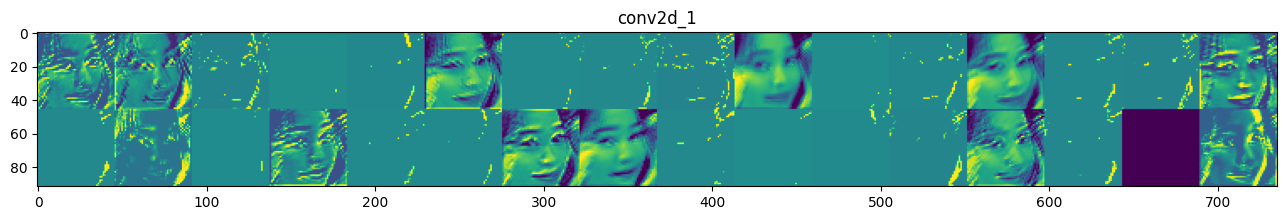

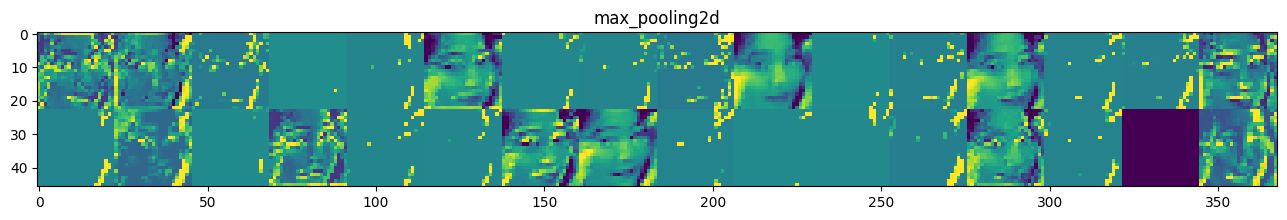

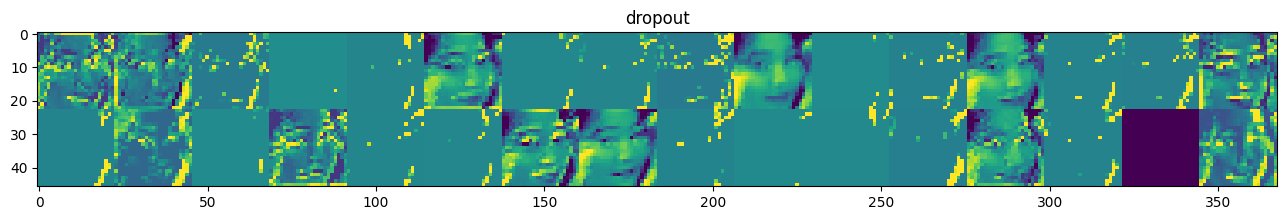

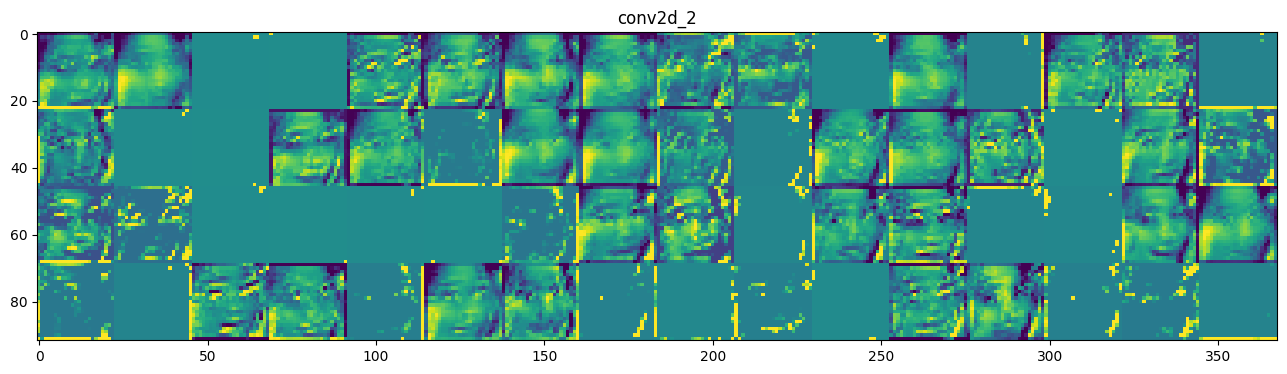

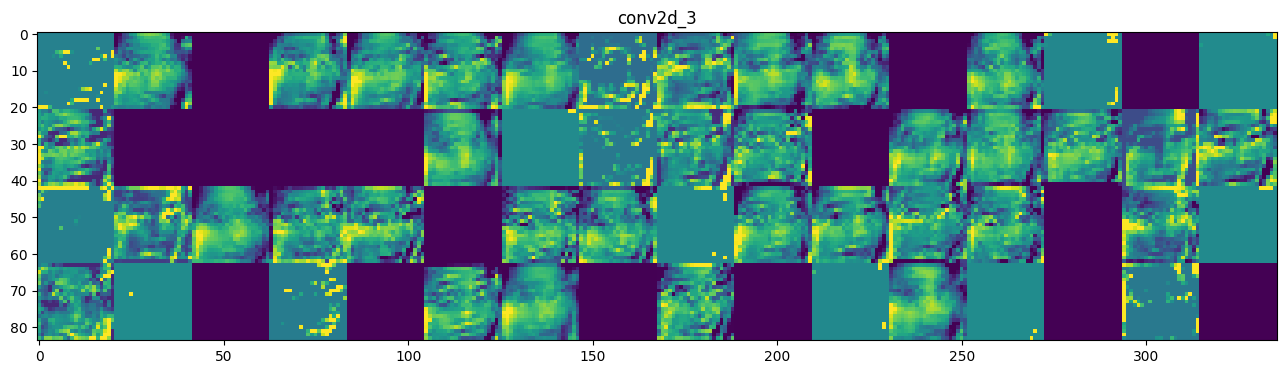

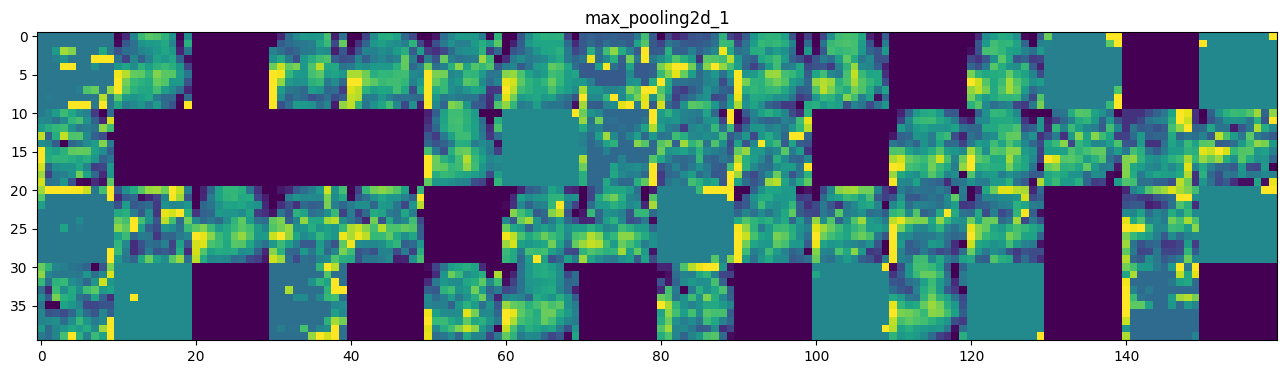

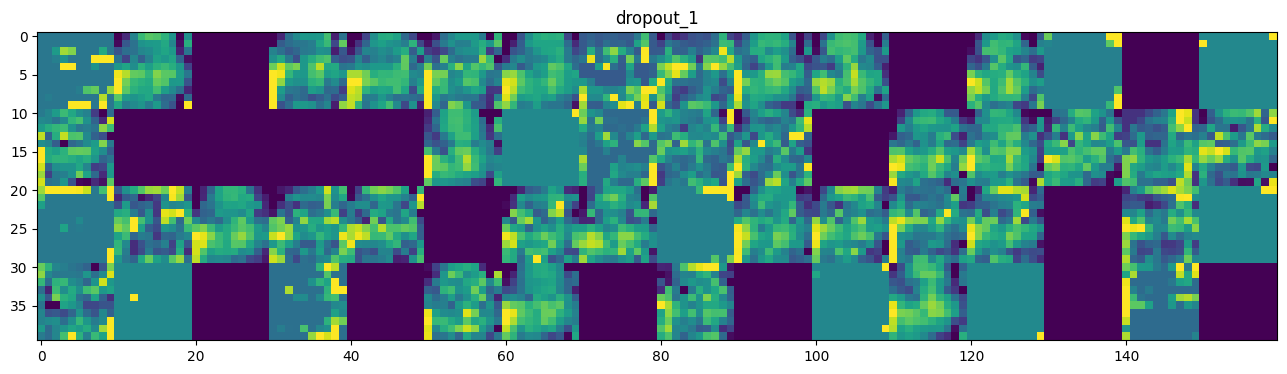

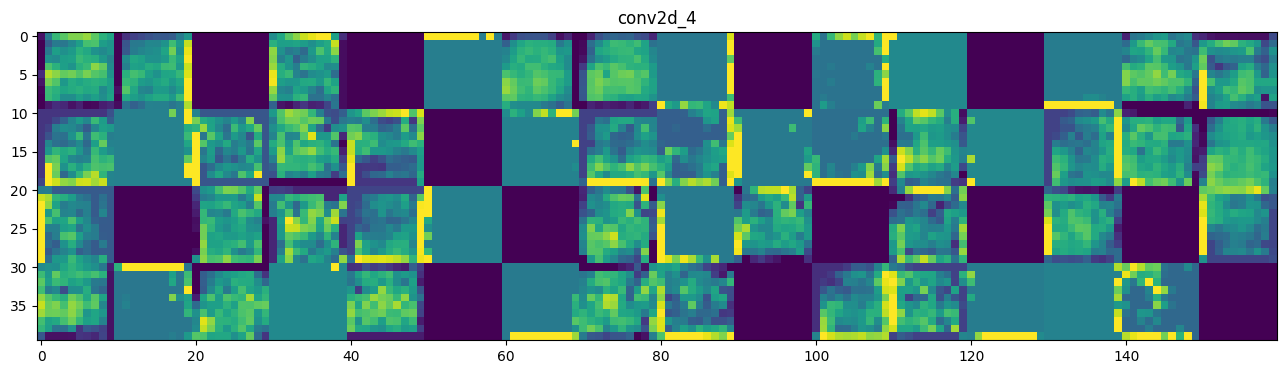

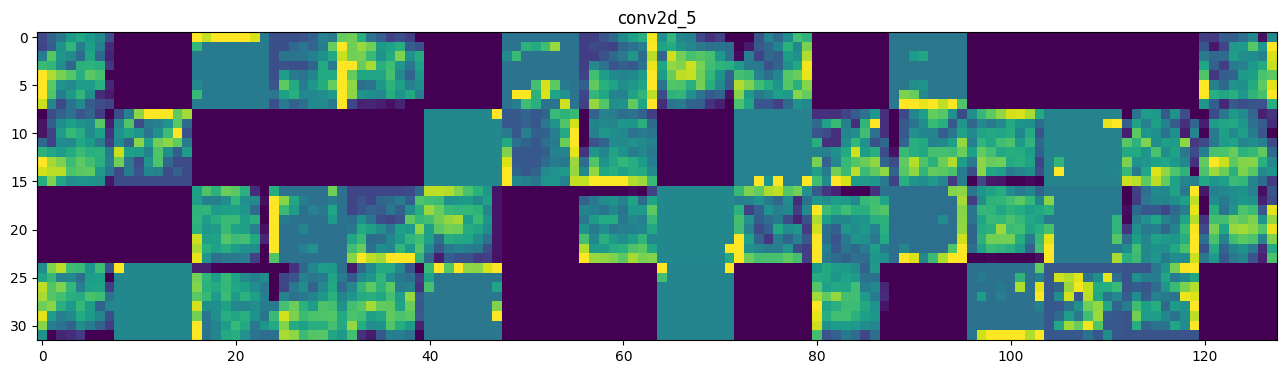

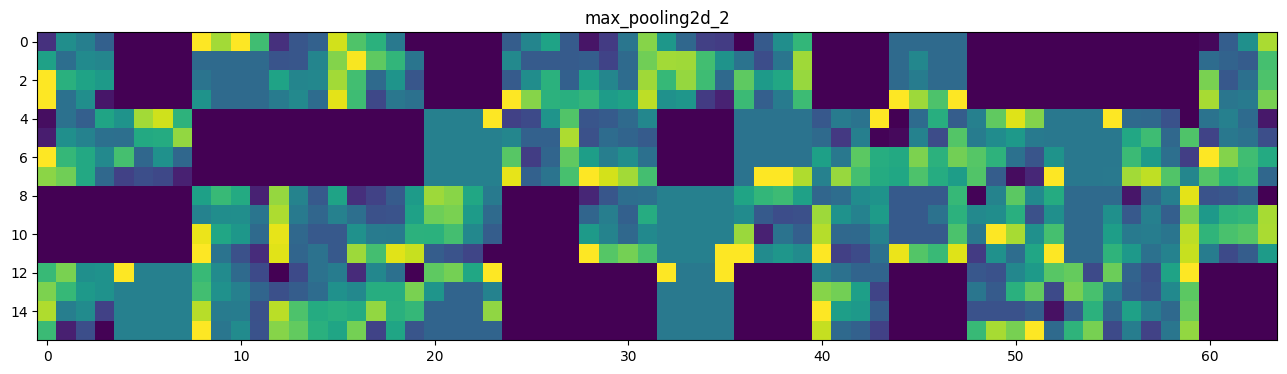

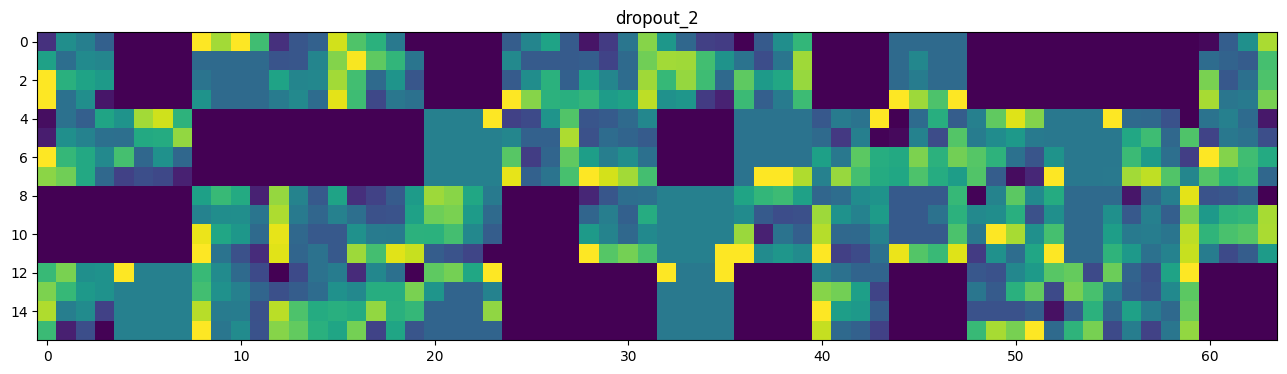

In [28]:
res = model.predict(gray_face_image)
activations = activation_model.predict(gray_face_image)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.savefig(layer_name, dpi=300)

###Train model & result visualization

<ipython-input-29-f4a5c446807d>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),


Epoch 1/200
29/29 [==============================] - 22s 475ms/step - loss: 1.8308 - accuracy: 0.2424 - val_loss: 1.8156 - val_accuracy: 0.2494
Epoch 2/200
29/29 [==============================] - 13s 457ms/step - loss: 1.8054 - accuracy: 0.2512 - val_loss: 1.8061 - val_accuracy: 0.2494
Epoch 3/200
29/29 [==============================] - 15s 495ms/step - loss: 1.8013 - accuracy: 0.2496 - val_loss: 1.8048 - val_accuracy: 0.2494
Epoch 4/200
29/29 [==============================] - 14s 437ms/step - loss: 1.7942 - accuracy: 0.2488 - val_loss: 1.7845 - val_accuracy: 0.2491
Epoch 5/200
29/29 [==============================] - 13s 447ms/step - loss: 1.7944 - accuracy: 0.2516 - val_loss: 1.7826 - val_accuracy: 0.2491
Epoch 6/200
29/29 [==============================] - 13s 440ms/step - loss: 1.7901 - accuracy: 0.2531 - val_loss: 1.7851 - val_accuracy: 0.2499
Epoch 7/200
29/29 [==============================] - 14s 456ms/step - loss: 1.7904 - accuracy: 0.2539 - val_loss: 1.7836 - val_accuracy:

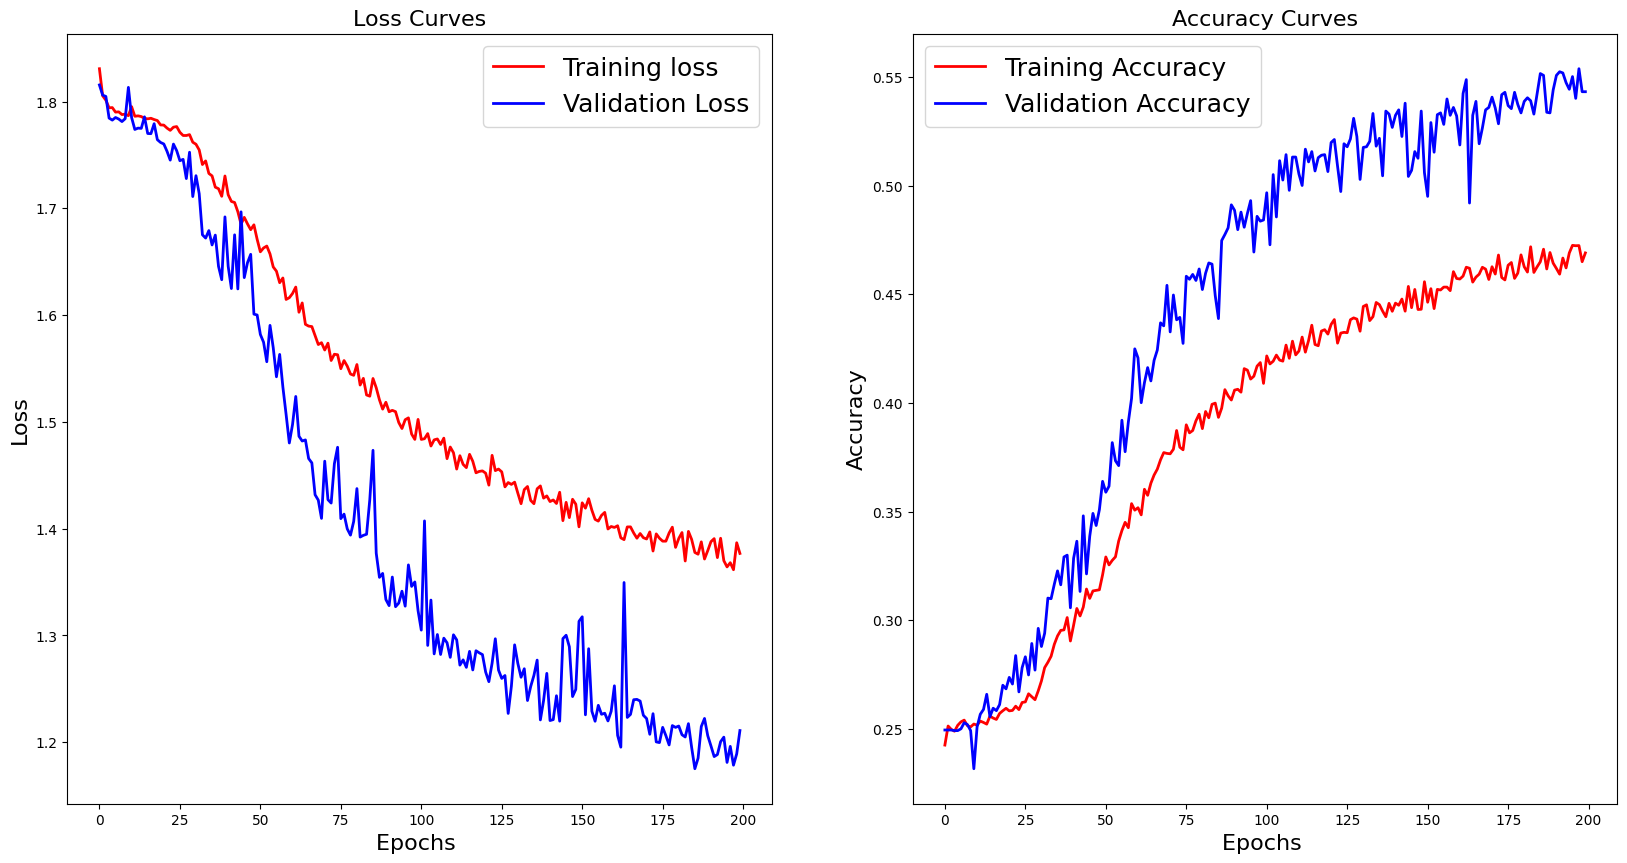

In [29]:
# Train model         ------------------------------------------------------------

# 이미지 데이터 증강
datagen = ImageDataGenerator(zoom_range=0.5,          # 랜덤하게 이미지 줌 하는 비율
                             rotation_range=45,       # 램덤하게 이미지 회전하는 비율 (0도~180도)
                             width_shift_range=0.3,   # 랜덤하게 이미지 가로로 이동하는 비율
                             height_shift_range=0.3,  # 랜덤하게 이미지 세로로 이동하는 비율
                             horizontal_flip=True,    # 랜덤하게 이미지 수평 뒤집기
                             vertical_flip=True)     # 랜덤하게 이미지 수직 뒤집기

# 모델 학습을 위한 파라미터 설정
batch_size = 1024
n_epochs = 200
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                              epochs=n_epochs,
                              validation_data=(test_data, test_labels_onehot)
                             )

# Model Evaluate         ------------------------------------------------------------
# Loss Curves
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.title('Loss Curves',fontsize=16)
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

# Accuracy Curves
plt.subplot(122)
plt.title('Accuracy Curves',fontsize=16)
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

plt.savefig("Model_Evaluate", dpi=300)
plt.show()

## FER test

I found 1 face(s) in this photograph.

A face is located at pixel location(offset : 15) Top: 154, Left: 205, Bottom: 591, Right: 643



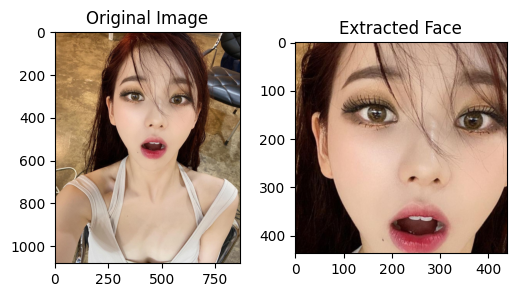

1/1 [==============================] - 0s 21ms/step


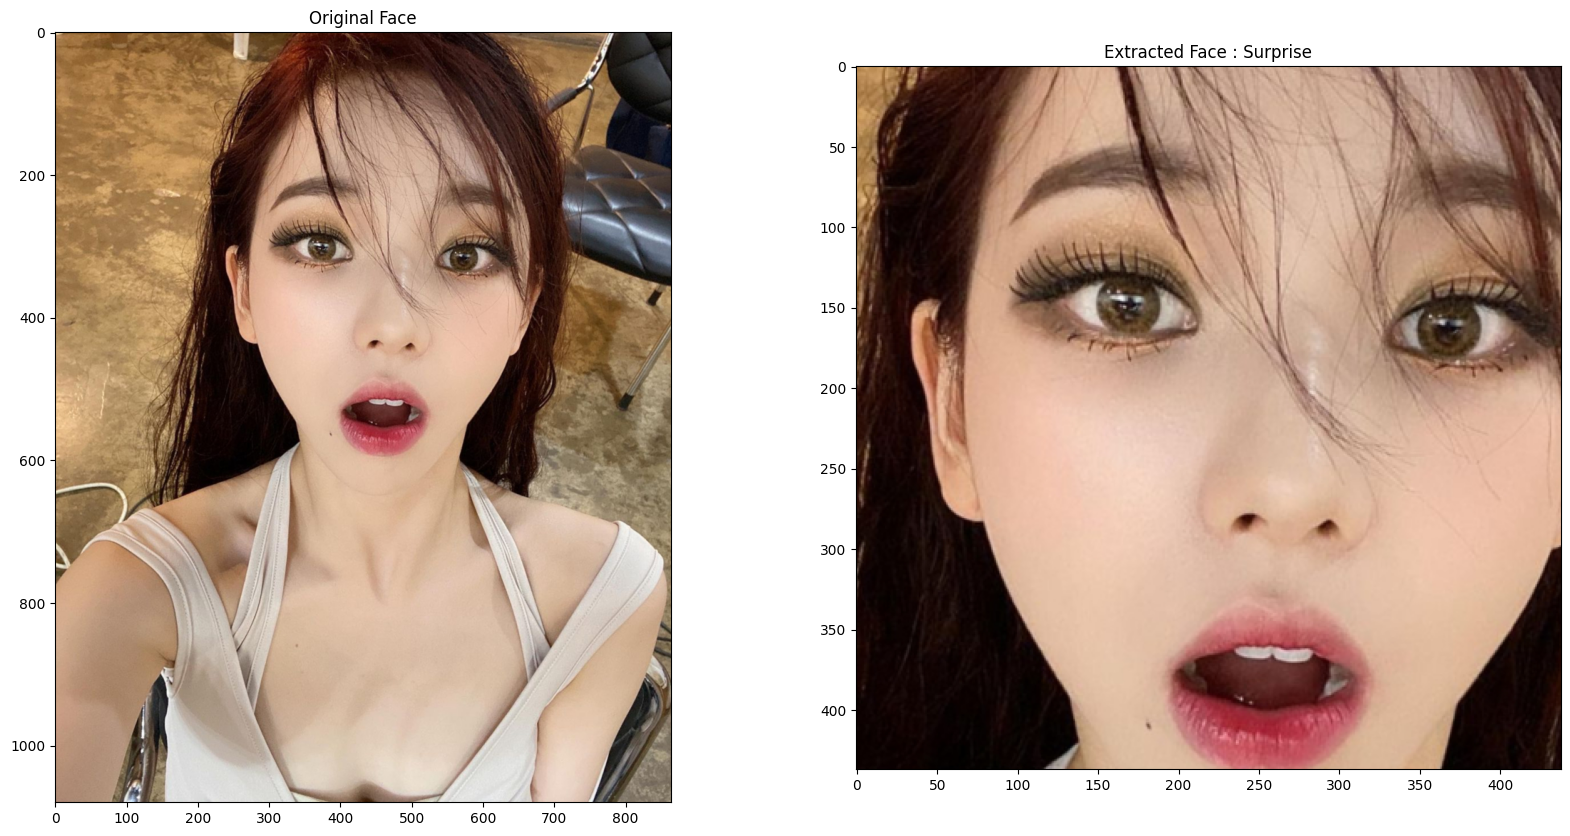

In [42]:
# 감정 분석 모델 테스트         ------------------------------------------------------------

image = face_recognition.load_image_file(data_path + 'Karina_0008.jpg')

face_image, gray_face_image = detect_face(image)

# 모델 추론
input_data = gray_face_image
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'Angry'
elif result == 1:
    emotion = 'Disgust'
elif result == 2:
    emotion = 'Fear'
elif result == 3:
    emotion = 'Happy'
elif result == 4:
    emotion = 'Sad'
elif result == 5:
    emotion = 'Surprise'
elif result == 6:
    emotion = 'Neutral'

# 시각화
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.title("Original Face")
plt.imshow(image)

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_image)

plt.savefig("DetectFace_Test", dpi=300)
plt.show()